In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from tqdm.auto import tqdm
from IPython.display import clear_output
from pathlib import Path
from PIL import Image

from loader import DataLoader
from register import AffineRegistration

DATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
METADATA_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/data.h5"
STACKREG_DIR = Path("/Users/farhanoktavian/imperial/thesis/sandbox/dataset/stackreg5")

run_loader = DataLoader(DATA_DIR, METADATA_DIR)

In [2]:
runs_txt = """HS001-Run04
    HS002-Run03
    HS005-Run08
    HS006-Run12
    HS007-Run04
    HS008-Run04
    HS009-Run06
    HS011-Run02
    HS012-Run04
    HS014-Run02
    HS015-Run03
    HS016-Run04
    HS017-Run02
    HS019-Run08
    HS020-Run06
    HS021-Run04
    HS022-Run04
    HS023-Run08
    HS025-Run04
    HS026-Run03
"""
run_tuples = [tuple(run.split("-")) for run in runs_txt.split()]

filtered_runs = []
for sample in tqdm(run_loader.samples):
    runs = sample.runs
    for run in runs:
        if (run.sample_id, run.run_id) not in run_tuples:
            continue
        clear_output(wait=True)

        run_coll = 0
        SI = run.get_spectral_image(wavelength=600, collection_idx=run_coll)
        MI = run.get_label_image(channel="bw")

        try:
            run.get_spectral_images(collection_idx=run_coll, channel="b")
        except:
            continue

        filtered_runs.append(run)

100%|██████████| 29/29 [00:04<00:00,  6.49it/s]


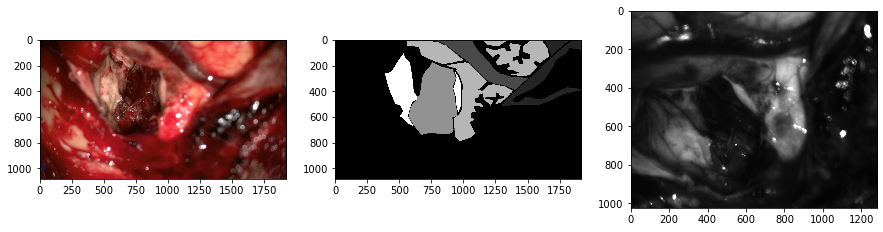

In [3]:
temp_run = filtered_runs[3]
temp_run

# show microscope, label mask, and spectral image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(temp_run.get_label_image())
axes[1].imshow(temp_run.get_label_mask(use_id=True), cmap="gray")
axes[2].imshow(temp_run.get_spectral_image(wavelength=600), cmap="gray", vmin=0, vmax=255)

plt.show()

In [4]:
w, h = temp_run.get_spectral_image(wavelength=600).shape
num_spectra = 29

reg = AffineRegistration()

x_data = np.zeros((len(filtered_runs), w, h, num_spectra), dtype=np.uint8)
y_data = np.zeros((len(filtered_runs), w, h), dtype=np.uint8)

for i, run in enumerate(filtered_runs):
    clear_output(wait=True)
    print("Processing run {}/{}".format(i+1, len(filtered_runs)))
    SIs = run.get_spectral_images()
    SI = run.get_spectral_image(wavelength=580)
    MI = run.get_label_image(channel="bw")
    mask = run.get_label_mask(use_id=True)

    for j, spec_img in enumerate(SIs):
        x_data[i, :, :, j] = SIs[j]
    
    # register MI to SI
    _, M = reg.register(MI, SI)
    mask_reg = None
    if M is not None:
        rows, cols = SI.shape
        mask_reg = cv2.warpAffine(mask, M, (cols, rows))
    
    y_data[i] = mask_reg

y_data = np.expand_dims(y_data, axis=-1)

print(x_data.shape)
print(y_data.shape)

Processing run 20/20
(20, 1024, 1280, 29)
(20, 1024, 1280, 1)


In [6]:
new_x_data, new_y_data = np.array([]), np.array([])

for i in range(0, len(x_data)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 18))
    ax[0].imshow(x_data[i, :, :, 18], cmap='gray')
    ax[1].imshow(y_data[i, :, :, 0], cmap='gray')
    plt.show()

    keep = input("Keep image? (y/n)")
    if keep == 'y':
        if new_x_data.shape[0] == 0:
            new_x_data = np.array([x_data[i]])
            new_y_data = np.array([y_data[i]])
        else:
            new_x_data = np.append(new_x_data, [x_data[i]], axis=0)
            new_y_data = np.append(new_y_data, [y_data[i]], axis=0)
    
    clear_output(wait=True)

print(new_x_data.shape)
print(new_y_data.shape)

(19, 1024, 1280, 29)
(19, 1024, 1280, 1)


In [7]:
with open('new_x_data.npy', 'wb') as f:
    np.save(f, new_x_data)

with open('new_y_data.npy', 'wb') as f:
    np.save(f, new_y_data)

In [61]:
count_images = new_x_data.shape[0]
train_images = int(count_images * 0.7)
test_images = count_images - train_images
print(count_images, train_images, test_images)

train_idxs = np.random.randint(count_images, size=train_images)
test_idxs = [i for i in range(count_images) if i not in train_idxs]

train_x = new_x_data[train_idxs, :, :, :]
train_y = new_y_data[train_idxs, :, :, :]

X_train = train_x.reshape(-1, train_x.shape[-1])
Y_train = train_y.reshape(-1)

dataset = pd.DataFrame(X_train)
dataset['label'] = Y_train
# remove zero labelled rows
dataset = dataset[dataset['label'] != 0]

X_train = dataset.iloc[:, :-1].values
Y_train = dataset.iloc[:, -1].values

test_x = new_x_data[test_idxs, :, :, :]
test_y = new_y_data[test_idxs, :, :, :]

20 14 6


In [63]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, Y_train)
